In this notebook, we will use data analysis of the dataset provided to extract 4-6 meta-categories of the different product categories that exist within the provided dataset. The reasoning for this is that we believe data analysis will allow us to capture potential 'hidden' product categories, of item categories that are semantically similar without appearing so to the human eye. 
First we will download the data, analyze it, clean it. Then we will preprocess (lemmatize) it and use a pre-trained transformer to encode the semmantic links within the product categories. Next, we will use k-means clustering, with max 4-6 clusters, on the transformed data to find the overarching "meta-categories" between the categories in the dataset. 

In [1]:
%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\karel\.cache\kagglehub\datasets\datafiniti\consumer-reviews-of-amazon-products\versions\5


In [2]:
# Check the files in the folder 
import os
print(os.listdir(path))

['1429_1.csv', 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv']


In [3]:
# Load the dataset into a pandas DataFrame
import pandas as pd
file_path = os.path.join(path, "1429_1.csv")
df1 = pd.read_csv(file_path)
# Display preliminary information about the dataset
print("Dataset shape:", df1.shape)
print("Columns in the dataset:", df1.columns)
print("Description of the dataset:\n", df1.describe())


Dataset shape: (34660, 21)
Columns in the dataset: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')
Description of the dataset:
         reviews.id  reviews.numHelpful  reviews.rating  reviews.userCity  \
count          1.0        34131.000000    34627.000000               0.0   
mean   111372787.0            0.630248        4.584573               NaN   
std            NaN           13.215775        0.735653               NaN   
min    111372787.0            0.000000        1.000000               NaN   
25%    111372787.0            0.000000        4.000000               NaN   
50%    111372787.0            0.000000        5.00000

C:\Users\karel\AppData\Local\Temp\ipykernel_92400\618624634.py:4: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file_path)


In [4]:
# Load the dataset into a pandas DataFrame
import pandas as pd
file_path = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df2 = pd.read_csv(file_path)
# Display preliminary information about the dataset
print("Dataset shape:", df2.shape)
print("Columns in the dataset:", df2.columns)
print("Description of the dataset:\n", df2.describe())
# Display the first few rows of the DataFrame
print("First few rows of the dataset:\n", df2.head())

Dataset shape: (5000, 24)
Columns in the dataset: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
Description of the dataset:
          reviews.id  reviews.numHelpful  reviews.rating
count  2.900000e+01         5000.000000     5000.000000
mean   1.858740e+08            0.312400        4.596800
std    2.084040e+07            3.111582        0.731804
min    1.082112e+08            0.000000        1.000000
25%    1.851185e+08            0.000000        4.000000
50%    1.880757e+08            0.000000        5.000000
75%    1.981949e+08            0.000000        5.000000
max    2.027812e+08          10

In [5]:

# Load the dataset into a pandas DataFrame
import pandas as pd
file_path = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df3 = pd.read_csv(file_path)
# Display preliminary information about the dataset
print("Dataset shape:", df3.shape)
print("Columns in the dataset:", df3.columns)
print("Description of the dataset:\n", df3.describe())

Dataset shape: (28332, 24)
Columns in the dataset: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
Description of the dataset:
          reviews.id  reviews.numHelpful  reviews.rating
count  4.100000e+01        16115.000000    28332.000000
mean   1.840066e+08            0.529321        4.514048
std    2.337036e+07            9.345017        0.934957
min    1.116244e+08            0.000000        1.000000
25%    1.843344e+08            0.000000        4.000000
50%    1.885078e+08            0.000000        5.000000
75%    1.988160e+08            0.000000        5.000000
max    2.085304e+08         

In [6]:
# For all datasets, drop the columns that are not needed to build a model that clusters product categories
columns_to_keep = ['name', 'categories', 'primaryCategories']
columns_to_drop1 = [col for col in df1.columns if col not in columns_to_keep]
df1.drop(columns=columns_to_drop1, inplace=True)
columns_to_drop2 = [col for col in df2.columns if col not in columns_to_keep]
df2.drop(columns=columns_to_drop2, inplace=True)
columns_to_drop3 = [col for col in df3.columns if col not in columns_to_keep]
df3.drop(columns=columns_to_drop3, inplace=True)
# Concatenate the three DataFrames into one
df = pd.concat([df1, df2, df3], ignore_index=True)






In [7]:
# Remove duplicate product names, categories and primary categories
df.drop_duplicates(subset=['name', 'categories', 'primaryCategories'], inplace=True)
# remove Nan values
df.dropna(subset=['name', 'categories', 'primaryCategories'], inplace=True)

# Display the first few rows of the combined DataFrame

print("Combined dataset shape:", df.shape)
print("Columns in the combined dataset:", df.columns)
print("Description of the combined dataset:\n", df.describe())
print("Number of unique product names:", df['name'].nunique())

# Display the unique values in the 'categories' and 'primaryCategories' columns

print("Unique primary categories:", df['primaryCategories'].unique())


Combined dataset shape: (81, 3)
Columns in the combined dataset: Index(['name', 'categories', 'primaryCategories'], dtype='object')
Description of the combined dataset:
                                                      name  \
count                                                  81   
unique                                                 79   
top     Amazon Echo Show Alexa-enabled Bluetooth Speak...   
freq                                                    2   

                                               categories primaryCategories  
count                                                  81                81  
unique                                                 76                10  
top     Fire Tablets,Tablets,All Tablets,Amazon Tablet...       Electronics  
freq                                                    4                59  
Number of unique product names: 79
Unique primary categories: ['Electronics' 'Electronics,Hardware' 'Office Supplies,Electronics'
 'El

In [8]:
# Clean the text from the primary categories column
def clean_text(text):
    # Remove leading and trailing whitespace
    text = text.strip()
    # Remove special characters and digits
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    # Convert to lowercase
    text = text.lower()
    # Remove multiple spaces
    text = ' '.join(text.split())
    return text
# Apply the cleaning function to the dataframe columns
df['name'] = df['name'].apply(clean_text)
df['categories'] = df['categories'].apply(clean_text)
df['primaryCategories'] = df['primaryCategories'].apply(clean_text)
# Display the cleaned unique values in the 'primaryCategories' column
print("Cleaned unique primary categories:", df['primaryCategories'].unique())

Cleaned unique primary categories: ['electronics' 'electronicshardware' 'office supplieselectronics'
 'electronicsmedia' 'health beauty' 'office supplies'
 'animals pet supplies' 'home garden' 'electronicsfurniture'
 'toys gameselectronics']


In the result above, we can see from our own observation that the primary categories can be divided into 5 categories: electronics, health beauty, office supplies, animals pet supplies and home garden. However, in order to be as thorough as possible as data scientists, we are going to analyze the categories data below to see if we can extract some hidden categories that we otherwise would have missed. 
First we will clean, tokenize and lemmatize the text in the categories and primary categories columns. Next we will use SentenceTransformer to encode semantic similarity between this cleaned text. 

In [9]:
# Preprocess the text data for embedding
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# make a local copy of the DataFrame to avoid modifying the original
df = df.copy()
# Use a text preprocessing pipeline to clean and prepare the text data
# This function will tokenize, remove stopwords, punctuation, and lemmatize the text
def text_preprocessing_pipeline(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)

    # Step 2: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

    # Step 3: Remove punctuation and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens]  # Keep only letters
    tokens = [word for word in tokens if word]  # Remove empty strings

    # Step 4: Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)
# Apply the preprocessing function to the 'name', 'categories', and 'primaryCategories' columns so that these are clean and ready for semantic embedding
df['name'] = df['name'].apply(text_preprocessing_pipeline)
df['categories'] = df['categories'].apply(text_preprocessing_pipeline)
df['primaryCategories'] = df['primaryCategories'].apply(text_preprocessing_pipeline)
# Merge the 'categories', and 'primaryCategories' columns into a single column for embedding
df['cleaned_text'] = df['categories'] + ' ' + df['primaryCategories']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
%pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Load a pre-trained SentenceTransformer model for semantic embedding
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
unique_texts = df['cleaned_text'].unique()
# Generate embeddings for the unique texts
embeddings = model.encode(unique_texts, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


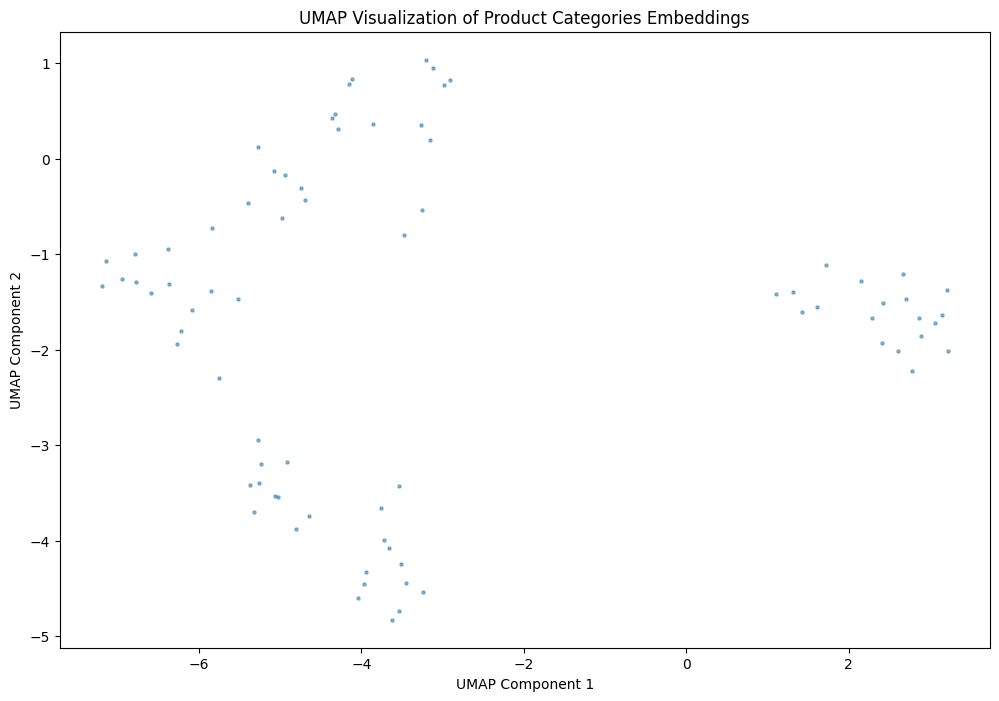

In [13]:
# Visualize the embeddings using UMAP
import umap
import matplotlib.pyplot as plt
# Create a UMAP instance and fit it to the embeddings
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings.cpu().numpy())
# Plot the UMAP embeddings
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5, alpha=0.5)
plt.title('UMAP Visualization of Product Categories Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different numbers of clusters to find the optimal number
best_score = -1
best_k = 0
for k in range(4, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans.fit_predict(embeddings)

In [ ]:
from collections import defaultdict

clusters = defaultdict(list)
for cat, label in zip(unique_texts, final_labels):
    # Use the cleaned text as the key for clustering
    clusters[label].append(cat)

# Print to inspect
for label, cats in clusters.items():
    print(f"Meta-category {label}:")
    print(cats)
    print()


Meta-category 2:
['computerselectronics featurestabletselectronicsipad tabletskindle ereadersipad accessoriesusedtabletsereadersereaders accessoriescomputerstablets networkingusedcomputers accessoriesipads tabletsall tabletstablets ereaderscomputers tabletsamazontablets ebook reader electronics', 'computer accessoriestablet ereader accessoriesamazon device accessorieselectronicspower adapter cablescomputers featurescell phone accessoriescell phone battery powerdigital device accessorytablet accessoriesfeatured brandskindle fire nd generation accessorieskindle storepower adapter cableselectricalhometablets ereaderschargers adapterschargers adapterselectronics featuresfire tablet accessoriesamazon book reader accessorycell phonesamazon device accessorieshome improvementfire th generation accessoriesamazon devicescables charger electronics', 'officeebook readerselectronics featureswalmart businesstabletselectronicsamazon ereadersoffice electronicsipad tabletskindle ereadersall tabletsamaz

Now that we have created clusters via unsupervised learning, we assign human-readable names to each one by: looking at the category names in each cluster and summarizing each group using GPT. For the sake of convenience, we have let the contents of each cluster above be analysed by Claude AI to suggest names based on commonalities between the categories. This yielded the following suggestions: 

Meta-Category 0: Media Streaming & TV Equipment

Meta-Category 1: Tablets & Mobile Computing

Meta-Category 2: E-readers & Digital Reading Accessoires (makes sense that this category is big given that Amazon started out selling books)

Meta-Category 3: Office supplies & Pet Products

Meta-Category 4: Smart Home & Voice Assistants

Meta-Category 5: Batteries & Kitchen Storage

Note that categories 3 & 5 appear to contain mixed product types that don't have strong thematic coherence, suggesting they may need further refinement in the clustering analysis, or that these need a separate category. 
We believe that the best way to solve this is to use our own human common-sense to merge some meta-categories, so that we can have separate categories for Pet Products and Kitchen Storage as well.


We suggest to merge the following Meta-Categories [Tablets & Mobile Computing + E-Readers & Digital Reading Accessoires] into : Portable Electronics. Next to that, we suggest to merge the Meta-Categories [Media Streaming & TV Equipment + Smart Home & Voice Assistants] into : Connected Home Electronics. That leaves us with the following final meta-categories:

Meta-Category 1: Portable Electronics

Meta-Category 2: Connected Home Electronics

Meta-Category 3: Office Supplies

Meta-Category 4: Pet Products

Meta-Category 5: Batteries

Meta-Category 6: Kitchen Storage
